# Predict Ratings using Review Text

This notebook consists of code that will:

1. Read a csv file containing pre-tokenized reviews. They were processed and tokenized in `Project_NLP.ipynb`.
2. Generate word vectors using Gensim Word2Vec.
3. Use word vectors to fit Random Forest, Support Vector, Logistic Regression models.
4. Use GloVe Global Vectors for word representation to fit the same models (for comparison).
5. Construct and fit a keras deep learning model to predict ratings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ast
import re
import time

import nltk
import gensim
from gensim.models import Word2Vec

# Read in Tokenized Reviews from file

In [2]:
reviews_df = pd.read_csv("csv_files/reviews.csv")

#Reviews are stored as one string. Need to convert to a list of strings.
reviews_df.review_tokenized = reviews_df.review_tokenized.map(ast.literal_eval)

# Set Data and Target variables

In [3]:
data = reviews_df.review_tokenized
target = reviews_df.star_rating

In [4]:
data.head()

0    [grits, this_one, southern_food, fried_chicken...
1    [brunch, enjoyable, mimosa_starter, eggs_bened...
2    [you're_looking_for, meal_lazy_sunday, morning...
3    [the_best, can_describe, shabby_chic_interior,...
4    [dinner_here_last, night, i'm_still_thinking_a...
Name: review_tokenized, dtype: object

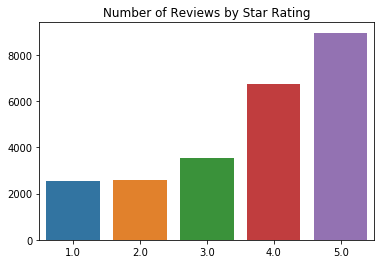

In [5]:
value_counts = target.value_counts()
sns.barplot(x=value_counts.index,y=value_counts.values);
plt.title('Number of Reviews by Star Rating');

### Define remove phrases function in the event that phrase removal is desired.

Removes underscores from tokens and re-tokenizes.

In [6]:
def phrase_clear(text_block):
    """
    Removes underscores from tokens in tokenized data. Returns re-tokenized text.
    INPUT:
    text_block = tokenized text block containing n-grams to be removed.
    OUTPUT:
    Tokenized text block that has n-grams transformed back into individual words.
    """
    cleared = []
    for idx, word in enumerate(text_block):
        cleared.extend(word.split("_"))
    return cleared

In [7]:
data = data.map(phrase_clear)

# Train / Test Split

Split within each star rating to ensure all rating levels are covered.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)

((21910,), (2435,))

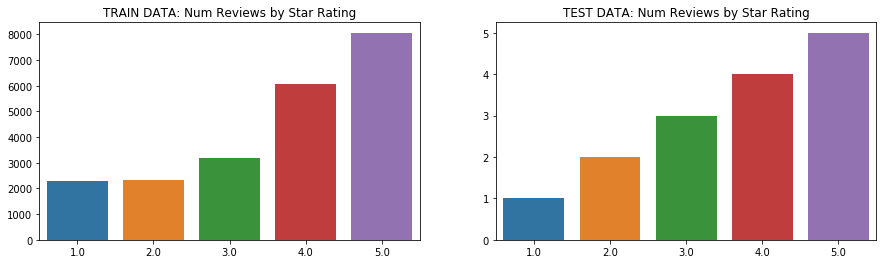

In [10]:
#plt.figure(figsize=(20,10))
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.barplot(x=train_counts.index,y=train_counts.values, ax=ax1)
sns.barplot(x=test_counts.index,y=test_counts.index, ax=ax2)
ax1.set_title('TRAIN DATA: Num Reviews by Star Rating');
ax2.set_title('TEST DATA: Num Reviews by Star Rating');

y_train.shape, y_test.shape

# Generate Word Embeddings

In [11]:
print("Generate Word Vectors:", end=' ')
start = time.time()
model = Word2Vec(X_train,size=100,window=5,min_count=1,workers=4)
model.train(data,total_examples=model.corpus_count,epochs=10)
end = time.time()
print(round(end-start,2),"seconds")

Generate Word Vectors: 19.15 seconds


In [12]:
#Save embedded word vector space
wv = model.wv
print(len(wv.vocab),"unique words in the dataset.")

30362 unique words in the dataset.


In [12]:
#Need a way to transform a tokenized review (because test data will not be used to train the Word2Vec model)

def w2v_transform(tokens, w2v_model):
    """
    This function generates a w2v vector for a set of tokens (a review). This is done by taking 
    the mean of each token in the review.
    """
    vectors = []
    for token in tokens:
        #Using a try/except because there may be an unrecognized token in the review.
        try:
            vec = list(w2v_model[token])
            vectors.append(vec)
        except:
            pass
    
    return np.mean(np.array(vectors), axis=0)

# Predict Ratings

In [13]:
#Sklearn Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
#from sklearn.decomposition import PCA

#XGBoost
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from xgboost import XGBClassifier

## Define some Classes and Functions to help with Predicting Ratings

### W2vVectorizer Class
Used to creat mean word embeddings. The class has fit and transform functions so that it may be used in an sklearn Pipeline.

In [14]:
#Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    
    def __init__(self, model):
        self.w2v = model
        
        #If using GloVe the model is in a dictionary format
        if isinstance(model, dict):
            if len(model) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(model[next(iter(glove))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = model.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self
            
    #def transform(self, X):
    #    return np.array([
    #        np.mean([self.w2v.get_vector(w) for w in words], axis=0) for words in X])
    
    #def transform(self, X):
    #    text_block_vector = []
    #    for words in X:
    #        sentence_vector = []
    #        for w in words:
    #            try:
    #                vec = list(self.w2v.get_vector(w))
    #                sentence_vector.append(vec)
    #            except:
    #                pass
    #        text_block_vector.append(np.mean(sentence_vector, axis=0))
    #    return np.array(text_block_vector)

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens (a review). This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

### Custom Accuracy Function
Provides an accuracy score where being off by 1 on prediction gives partial credit. The idea is that predicting 2 stars for a 1 star review is not bad and is better than predicting 5 stars. This function is used in conjunction with a standard accuracy calculation for comparison purposes.

In [54]:
def custom_accuracy(y_true, y_pred, threshold=1, credit_given=0.5):
    """
    If y_pred is off by threshold or less, give partial credit according to credit_given.
    INPUTS:
    y_true       = True label.
    y_pred       = Predicted label.
    threshold    = Threshold for giving credit to inaccurate predictions. (=1 gives credit to predictions off by 1)
    credit_given = Partial credit amount for close but inaccurate predictions. (=0.5 give 50% credit)
    """
    predicted_correct = sum((y_true-y_pred)==0)
    predicted_off = sum(abs(y_true-y_pred)<=threshold) - predicted_correct
    custom_accuracy = (predicted_correct + credit_given*predicted_off)/len(y_true)
    return custom_accuracy

### Get Gridsearch Result
This function fits a GridSearchCV model and populates a dictionary containing the best model and accuracy results.

In [55]:
def get_gridsearch_result(name, estimator, param_grid, X_train, X_test, y_train, y_test, cv=2):
    grid_clf = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid_clf.fit(X_train,y_train)

    result = {}
    
    result['name'] = name
    result['model'] = grid_clf.best_estimator_
    result['model params'] = grid_clf.best_params_

    y_pred_train = grid_clf.predict(X_train)
    y_pred_test  = grid_clf.predict(X_test)

    result['accuracy train']  = round(accuracy_score(y_train,y_pred_train),4)
    result['accuracy test']   = round(accuracy_score(y_test,y_pred_test),4)
    result['custom accuracy train'] = round(custom_accuracy(y_train,y_pred_train),4)
    result['custom accuracy test']  = round(custom_accuracy(y_test,y_pred_test),4)

    return result

### Get Gridsearch for All Models
This function will perform a grisearch for a list of models, output the time taken, and return the results dictionaries for each gridsearch model.

In [56]:
def gridsearch_all_models(models, X_train, X_test, y_train, y_test, cv=2):
    """
    Perform a gridsearch on a list of models containing an estimator and parameter grid.
    INPUTS:
    models = List of tuples in the form (name, model, param_grid)
        name  = text name of the model
        model = model of pipeline model
        param_grid = parameters to be used for gridsearch
    X_train, X_test, y_train, y_test = train test split of data(X) and target(y).
    
    RETURNS:
    List of dictionaries containing gridsearch model, selected parameters, and accuracy scores.
    """
    
    print("GRIDSEARCH AND SCORE ALL MODELS:")
    start = time.time()
    results = []

    for name, model, param_grid in models:
        start_model = time.time()
        print("  ", name, end='')
        results.append(get_gridsearch_result(name=name,
                                             estimator=model,
                                             param_grid=param_grid,
                                             X_train=X_train,
                                             X_test=X_test, 
                                             y_train=y_train,
                                             y_test=y_test,
                                             cv=cv))

        end_model = time.time()
        print(":\t time", time.strftime('%H:%M:%S', time.gmtime(end_model-start_model)))

    end = time.time()
    print("TOTAL TIME:", time.strftime('%H:%M:%S', time.gmtime(end-start)))
    return results

In [68]:
#PARAMETER GRIDS FOR GRIDSEARCH
param_grid_rf  = [{'Random Forest__criterion': ['entropy'],
                   'Random Forest__max_depth': [6, 7],
                   'Random Forest__n_estimators': [100] }]

param_grid_svc = [{'Support Vector Machine__C': [1],
                   'Support Vector Machine__gamma': ['auto'] }]

param_grid_lr  = [{'Logistic Regression__solver': ['sag','lbfgs'],
                   'Logistic Regression__penalty': ['l2'],
                   'Logistic Regression__C': [.01, .1, 1],
                   'Logistic Regression__max_iter': [1000]}]

param_grid_xgb = [{'XGBoost Model__max_depth': [3],
                   'XGBoost Model__n_estimators': [100],
                   'XGBoost Model__learning_rate': [0.1, 0.2],
                   'XGBoost Model__gamma': [0, 1] }]

In [69]:
rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Random Forest", RandomForestClassifier(max_features='auto'))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Support Vector Machine", SVC())])
lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Logistic Regression", LogisticRegression(multi_class='multinomial'))])
xgb = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("XGBoost Model", XGBClassifier())])

models = [("Random Forest", rf, param_grid_rf),
          ("Support Vector", svc, param_grid_svc),
          ("Logistic Regression", lr, param_grid_lr),
          ("XGBoost Model", xgb, param_grid_xgb)]

#[{'max_depth': [4], 'n_estimators': [100], 'learning_rate': [0.1],'gamma': [0, 1] }]

In [ ]:
results.extend(gridsearch_all_models(models, X_train, X_test, y_train, y_test))

GRIDSEARCH AND SCORE ALL MODELS:
   Random Forest:	 time 00:01:44
   Support Vector:	 time 00:04:15
   Logistic Regression

In [62]:
pd.DataFrame(results)

,accuracy test,accuracy train,custom accuracy test,custom accuracy train,model,model params,name
0,0.4940,0.6018,0.6628,0.7323,"Pipeline(memory=None,\n steps=[('Word2Vec ...","{'Random Forest__criterion': 'entropy', 'Rando...",Random Forest
1,0.5626,0.6345,0.7415,0.7803,"Pipeline(memory=None,\n steps=[('Word2Vec ...","{'Support Vector Machine__C': 10, 'Support Vec...",Support Vector
2,0.5647,0.5860,0.7423,0.7514,"Pipeline(memory=None,\n steps=[('Word2Vec ...","{'Logistic Regression__C': 0.1, 'Logistic Regr...",Logistic Regression
3,0.5495,0.7527,0.7234,0.8447,"Pipeline(memory=None,\n steps=[('Word2Vec ...","{'XGBoost Model__gamma': 0, 'XGBoost Model__le...",XGBoost Model


### Predict Ratings using GloVe Word Vectors

In [17]:
#Using GloVe Vectors
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in wv.vocab.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [19]:
rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Random Forest", RandomForestClassifier(max_features='auto'))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Support Vector Machine", SVC())])
lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Logistic Regression", LogisticRegression(multi_class='multinomial'))])
xgb = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("XGBoost Model", XGBClassifier())])

glove_models = [("GloVe Random Forest", rf, param_grid_rf),
                ("GloVe Support Vector", svc, param_grid_svc),
                ("GloVe Logistic Regression", lr, param_grid_lr),
                ("GloVe XGBoost Model", xgb, param_grid_xgb)]

In [ ]:
results.extend(gridsearch_all_models(glove_models, X_train, X_test, y_train, y_test))

In [ ]:
pd.DataFrame(results)

# Word Embeddings - Deep Learning

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [23]:
y = pd.get_dummies(target).values

In [24]:
#tokenizer = text.Tokenizer(num_words=20000)
#tokenizer.fit_on_texts(list(reviews_df.review))
#tokenized_reviews = tokenizer.texts_to_sequences(reviews_df.review)
#X_t = sequence.pad_sequences(tokenized_reviews, maxlen=100)

tokenizer = text.Tokenizer(num_words=20000)
#tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(data)
tokenized_reviews = tokenizer.texts_to_sequences(data)
X_t = sequence.pad_sequences(tokenized_reviews, maxlen=100)

In [25]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 41 different possible classes, so we use 41 neurons in our output layer
x = Dense(5, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 25)           15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [27]:
model.fit(X_t, y, epochs=5, batch_size=32, validation_split=0.1)

Train on 21910 samples, validate on 2435 samples
Epoch 1/5
21910/21910 [==============================] - 40s 2ms/step - loss: 1.3250 - acc: 0.4141 - val_loss: 1.2487 - val_acc: 0.4559
Epoch 2/5
21910/21910 [==============================] - 41s 2ms/step - loss: 1.0441 - acc: 0.5356 - val_loss: 1.1628 - val_acc: 0.4879
Epoch 3/5
21910/21910 [==============================] - 42s 2ms/step - loss: 0.8788 - acc: 0.6221 - val_loss: 1.2142 - val_acc: 0.5002
Epoch 4/5
21910/21910 [==============================] - 41s 2ms/step - loss: 0.7558 - acc: 0.6902 - val_loss: 1.4005 - val_acc: 0.4727
Epoch 5/5
21910/21910 [==============================] - 41s 2ms/step - loss: 0.6470 - acc: 0.7416 - val_loss: 1.5153 - val_acc: 0.4719
